# Introduction to NLP in TensorFlow

In [1]:
import tensorflow as tf
import pandas as pd
import zipfile

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP (text samples of Tweets labelled as disaster or not disaster)

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2023-09-25 14:01:29--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   725KB/s    in 0.8s    

2023-09-25 14:01:30 (725 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [3]:
# Unzip data
zip_ref = zipfile.ZipFile('nlp_getting_started.zip', 'r')
zip_ref.extractall()
zip_ref.close()

## Visualizing a text dataset

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target: {target}', '(real disaster)' if target > 0 else '(not real disaster)')
  print(f'Text:\n {text} \n')
  print('---\n')

Target: 0 (not real disaster)
Text:
 #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect 

---

Target: 0 (not real disaster)
Text:
 hermancranston: WIRED : Reddit will now quarantine offensive content http://t.co/wvn6GrIyPq (http://t.co/Rei3PuWP84Û_ Û_ 

---

Target: 0 (not real disaster)
Text:
 @crabbycale OH MY GOD THE MEMORIES ARE FLOODING BACK 

---

Target: 0 (not real disaster)
Text:
 @missambear your Tweet was quoted by @WIRED  http://t.co/E90J3vJOLc 

---

Target: 1 (real disaster)
Text:
 Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/ETg0prBP4G 

---



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

# Split train dataset
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [11]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [12]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers (tokenization)

In [13]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [14]:
# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # Define how many words in the vocabulary
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None, # Create groups of words
                                    output_mode='int',
                                    output_sequence_length=None, # How long is the sequence
                                    pad_to_max_tokens=True)

In [15]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [16]:
# Setup text vecorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [17]:
# Fit the text vecorizer to the training text
text_vectorizer.adapt(train_sentences)

In [18]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose a random sentence from training dataset and tokenizr it
random_sentence = random.choice(train_sentences)
print(f"Original text: \n {random_sentence} \n \nVectorized version: ")
text_vectorizer([random_sentence])

Original text: 
 @TeamHendrick @TeamHendrick @RIRInsider Fingers crossed that there will be a driver from Hendricks in Military Hospitality w/ @neanea2724! 
 
Vectorized version: 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[4458, 4458, 9062, 2999, 2506,   16,   74,   38,   21,    3,  900,
          20,    1,    4,  223]])>

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

In [21]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                            output_dim=128,
                            input_length=max_length)

embedding

In [22]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence} \
        \n \nEmbedded version:')
# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/aG65u29SGo         
 
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02806699, -0.04030044,  0.00293939, ...,  0.043054  ,
         -0.01190801,  0.00364707],
        [-0.04311464,  0.00338618, -0.04457052, ...,  0.01343994,
         -0.04370233, -0.03234605],
        [ 0.00297832,  0.0082568 ,  0.04872828, ...,  0.00896769,
          0.01633965,  0.00265064],
        ...,
        [ 0.02735803,  0.04157576, -0.00717028, ...,  0.01708149,
          0.04125171,  0.01072408],
        [ 0.0002256 , -0.04454612,  0.00486607, ...,  0.03456695,
         -0.01875448,  0.02626339],
        [ 0.02450157, -0.04068024, -0.01559861, ..., -0.019427  ,
          0.04502099, -0.03767353]]], dtype=float32)>

In [23]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.02806699, -0.04030044,  0.00293939, -0.04743407, -0.045459  ,
        -0.00451176, -0.03414013, -0.03558033, -0.00960432, -0.00551118,
         0.00843998, -0.02918465,  0.00428785,  0.02231516,  0.0344829 ,
        -0.02700414,  0.04745534, -0.00559132,  0.00422813, -0.01282398,
         0.02062534,  0.04811576,  0.0189348 , -0.04684624, -0.02322806,
        -0.02400814,  0.00124149, -0.03248389,  0.04807689,  0.02169999,
         0.00143977, -0.01342566, -0.02001215,  0.00179287,  0.00757339,
         0.02511612, -0.01753172,  0.02717408, -0.00598743,  0.04234192,
        -0.04278653, -0.02531482,  0.04933024, -0.02022108,  0.03031645,
         0.02930423, -0.03412659, -0.015666  ,  0.0056775 ,  0.02774867,
        -0.00876803,  0.01676556,  0.0362365 ,  0.03834131, -0.02678094,
         0.00444617,  0.0182131 , -0.00808402,  0.04939387, -0.00519975,
         0.03637448,  0.00833789, -0.01463998,  0.03091111, -0.02620108,
  

## Modelling a text dataset (running a seires of experiments)

* Baseline: Naive Bayes (sklearn)
* Model 1: Feed-foward neural network (dense model)
* Model 2: LTSM model (RNN)
* Model 3: GRU (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: ID Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

### Baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [25]:
# Create tokenization and modelling papeline
baseline = Pipeline([
                    ('tfidf', TfidfVectorizer()), # Convert words to numbers
                    ('clf', MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
baseline.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate our baseline
baseline_score = baseline.score(val_sentences, val_labels)
print(f'Baseline accuracy: {baseline_score*100:.2f}%')

Baseline accuracy: 79.27%


In [27]:
# Make predictions
baseline_preds = baseline.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluating function for our model experiments

* Evaluation metrics:
  * Accuracy
  * Precision
  * Recall
  * F1-score

In [28]:
# Function to evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, X_test, y_test):
  """
  Calculates model accuracy, precision, recall and f1-score of a binary classification tensor model.
  """
  # Get model predictions
  y_preds = tf.squeeze(tf.round(model.predict(X_test)))

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_test, y_preds) * 100

  # Calculate model precision, recall and f1-score average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_test, y_preds, average='weighted')

  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1-score": model_f1}
  return model_results

In [29]:
baseline_results = evaluate_model(model=baseline,
                                  X_test=val_sentences,
                                  y_test=val_labels)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

### Model 1: A simple Dense Model

In [30]:
# Create a tensorboard callback (need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory
  """

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

In [31]:
# Create a directory to save TensorBoard log
SAVE_DIR = 'model_logs'

In [32]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-d strings
x = text_vectorizer(inputs) # Turn the text input into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, binary outputs = sigmoid activation

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [33]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [34]:
 # Compile the model
 model_1.compile(loss="binary_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230925-140137
Epoch 1/5
215/215 [==============================] - 32s 114ms/step - loss: 0.6104 - accuracy: 0.6933 - val_loss: 0.5368 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4416 - accuracy: 0.8212 - val_loss: 0.4774 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3461 - accuracy: 0.8594 - val_loss: 0.4600 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2837 - accuracy: 0.8911 - val_loss: 0.4651 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2370 - accuracy: 0.9142 - val_loss: 0.4838 - val_accuracy: 0.7900


In [36]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4838 - accuracy: 0.7900


[0.483814537525177, 0.7900262475013733]

In [37]:
model_1_results = evaluate_model(model=model_1,
                                 X_test=val_sentences,
                                 y_test=val_labels)

model_1_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 79.00262467191601,
 'precision': 0.7964718621790533,
 'recall': 0.7900262467191601,
 'f1-score': 0.7866259949990327}

In [38]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))


array([False, False, False,  True])

## Visualizing learned embeddings

In [39]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [40]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [41]:
# Get the weight matrix of embedding layer
# These are the numerical representation of each token in our training data
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embessing_dim

(10000, 128)


Visualizing with tensorflow projector

In [42]:
embed_weights

array([[-0.00464515,  0.00848825,  0.06178759, ..., -0.04377846,
        -0.05359435, -0.04572634],
       [ 0.0135161 , -0.02402599,  0.05044798, ...,  0.01158504,
        -0.01092786, -0.00404139],
       [ 0.01633742, -0.0441418 , -0.00921555, ..., -0.02485814,
         0.03988824, -0.04363759],
       ...,
       [-0.04433475, -0.02028826, -0.02784386, ..., -0.00508859,
         0.01826521, -0.00212926],
       [-0.06631886, -0.03064414,  0.01246114, ..., -0.05671527,
        -0.07137674, -0.08000539],
       [-0.11177007, -0.10177055,  0.04467505, ..., -0.08872992,
        -0.03310663, -0.0763258 ]], dtype=float32)

In [43]:
# Create embedding files
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue # skip 0, it's padding
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + '\n')
  out_m.write(word + '\n')
out_v.close()
out_m.close()

In [44]:
# Download files from Colab to upload to projector
#try:
#  from google.colab import files
#  files.download('vectors.tsv')
#  files.download('metadata.tsv')
#except Exception:
#  pass

## Recurrent Neural Networks (RNN)

### Model 2: (LSTM)


In [45]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1, ), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(64, return_sequences=True) # when you're stacking RNN cells together, you need to return sequences
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [46]:
# Get a Summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [47]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTMS")])

Saving TensorBoard log files to: model_logs/model_2_LSTMS/20230925-140219
Epoch 1/5
215/215 [==============================] - 14s 51ms/step - loss: 0.2218 - accuracy: 0.9207 - val_loss: 0.5404 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1554 - accuracy: 0.9438 - val_loss: 0.6687 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1297 - accuracy: 0.9498 - val_loss: 0.6483 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1045 - accuracy: 0.9610 - val_loss: 0.8220 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0866 - accuracy: 0.9688 - val_loss: 1.0493 - val_accuracy: 0.7782


In [49]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[8.9182332e-04],
       [8.0005836e-01],
       [9.9974269e-01],
       [1.6031982e-02],
       [3.2249858e-04],
       [9.9758446e-01],
       [8.8828820e-01],
       [9.9973661e-01],
       [9.9955529e-01],
       [7.8669131e-01]], dtype=float32)

In [50]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [51]:
# Calculate model 2 results
model_2_results = evaluate_model(model=model_2,
                                 X_test=val_sentences,
                                 y_test=val_labels)

model_2_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 77.82152230971128,
 'precision': 0.7804499491198106,
 'recall': 0.7782152230971129,
 'f1-score': 0.7760126933653841}

In [52]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

### Model 3: (GRU)


In [53]:
# Build an RNN using GRU
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [54]:
# Get a summary
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [55]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230925-140245
Epoch 1/5
215/215 [==============================] - 14s 56ms/step - loss: 0.1580 - accuracy: 0.9369 - val_loss: 0.8198 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0858 - accuracy: 0.9667 - val_loss: 0.8550 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0685 - accuracy: 0.9740 - val_loss: 0.9292 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0627 - accuracy: 0.9766 - val_loss: 0.8230 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0541 - accuracy: 0.9775 - val_loss: 1.0062 - val_accuracy: 0.7795


In [57]:
# Evaluate the model
model_3_results = evaluate_model(model=model_3,
                                 X_test=val_sentences,
                                 y_test=val_labels)

model_3_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 77.95275590551181,
 'precision': 0.7811151206076258,
 'recall': 0.7795275590551181,
 'f1-score': 0.7776506830100394}

## Model 4: Bidirectional RNN

In [58]:
# Build a bidirectional
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [59]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [60]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
# Fit model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230925-140311
Epoch 1/5
215/215 [==============================] - 16s 56ms/step - loss: 0.1060 - accuracy: 0.9708 - val_loss: 0.8415 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0560 - accuracy: 0.9778 - val_loss: 1.2303 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0451 - accuracy: 0.9783 - val_loss: 1.4873 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0421 - accuracy: 0.9796 - val_loss: 1.4116 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0389 - accuracy: 0.9804 - val_loss: 1.4694 - val_accuracy: 0.7677


In [62]:
model_4_results = evaluate_model(model=model_4,
                                 X_test=val_sentences,
                                 y_test=val_labels)

model_4_results

24/24 [==============================] - 1s 4ms/step


{'accuracy': 76.77165354330708,
 'precision': 0.7681410880728078,
 'recall': 0.7677165354330708,
 'f1-score': 0.7662770891654436}

In [63]:
model_3_results

{'accuracy': 77.95275590551181,
 'precision': 0.7811151206076258,
 'recall': 0.7795275590551181,
 'f1-score': 0.7776506830100394}

## CNN for Text

### Model 5: Conv1D

In [64]:
# Test embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn taget text into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")

conv_1d_output = conv_1d(embedding_test) # pass the test embedding through conv1D layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the feature with the highest value

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [65]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [66]:
# Fit model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_conv_1d")])

Saving TensorBoard log files to: model_logs/model_5_conv_1d/20230925-140343
Epoch 1/5
215/215 [==============================] - 13s 47ms/step - loss: 0.1251 - accuracy: 0.9628 - val_loss: 0.8971 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0731 - accuracy: 0.9730 - val_loss: 1.0638 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0598 - accuracy: 0.9775 - val_loss: 1.1625 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0531 - accuracy: 0.9784 - val_loss: 1.1717 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0515 - accuracy: 0.9794 - val_loss: 1.1892 - val_accuracy: 0.7493


In [67]:
model_5_results = evaluate_model(model=model_5,
                                 X_test=val_sentences,
                                 y_test=val_labels)

model_5_results

24/24 [==============================] - 0s 3ms/step


{'accuracy': 74.93438320209974,
 'precision': 0.7488680244585756,
 'recall': 0.7493438320209974,
 'f1-score': 0.7488133386183109}

## Model 6: TensorFlowHub Pretrained Feature Extractor

In [68]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(["When you use the universal sentence enconder on a sentence, it turns into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[ 0.03795707 -0.07540288 -0.0206571   0.03720315 -0.05308544 -0.05606108
 -0.01270416  0.02363365  0.02747292  0.06997978 -0.01994188 -0.00836971
 -0.00516995  0.08771343  0.04247782 -0.10690617 -0.00620636 -0.01362402
 -0.04487966  0.0296159  -0.00735584  0.04043583  0.00236876  0.05695819
 -0.05587536  0.09654909 -0.01866602 -0.05685634 -0.00830049  0.01731144
  0.03159057 -0.01349702 -0.01478995 -0.01830282 -0.10646761  0.00622116
  0.03496791  0.02263189  0.02511197  0.04046946  0.02315824  0.01218709
  0.04568531  0.0106018   0.01508585  0.04553875 -0.03053699 -0.05650131
  0.01996034 -0.03955592], shape=(50,), dtype=float32)


In [69]:
# Create a Kera Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype="string",
                                        trainable=False,
                                        name="USE")

In [70]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [71]:
# Fit the model
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_6_use")])

Saving TensorBoard log files to: model_logs/model_6_use/20230925-140521
Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.4862 - accuracy: 0.7873 - val_loss: 0.4502 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.4149 - accuracy: 0.8151 - val_loss: 0.4442 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4068 - accuracy: 0.8168 - val_loss: 0.4455 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4030 - accuracy: 0.8221 - val_loss: 0.4436 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3992 - accuracy: 0.8240 - val_loss: 0.4413 - val_accuracy: 0.8228


In [72]:
# Evaluate model
model_6_results = evaluate_model(model=model_6,
                                 X_test=val_sentences,
                                 y_test=val_labels)

model_6_results

24/24 [==============================] - 1s 9ms/step


{'accuracy': 82.28346456692913,
 'precision': 0.8229723973525771,
 'recall': 0.8228346456692913,
 'f1-score': 0.8222698311121005}

## Model 7: TF Hub Pretrained USE but with 10% of training data

In [73]:
# Create subsets of 10% of the data
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [74]:
# Check the number of targets in our subset of data
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [75]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [76]:
# Model 7 = model 6but only 10% of data
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [77]:
# Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_use_10_percent")])

Saving TensorBoard log files to: model_logs/model_7_use_10_percent/20230925-140550
Epoch 1/5
22/22 [==============================] - 5s 86ms/step - loss: 0.6424 - accuracy: 0.7212 - val_loss: 0.6029 - val_accuracy: 0.7598
Epoch 2/5
22/22 [==============================] - 1s 50ms/step - loss: 0.5381 - accuracy: 0.8117 - val_loss: 0.5418 - val_accuracy: 0.7743
Epoch 3/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4711 - accuracy: 0.8248 - val_loss: 0.5041 - val_accuracy: 0.7822
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4271 - accuracy: 0.8307 - val_loss: 0.4908 - val_accuracy: 0.7795
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.3997 - accuracy: 0.8365 - val_loss: 0.4822 - val_accuracy: 0.7835


In [78]:
# Evaluate the model
model_7_results = evaluate_model(model=model_7,
                                 X_test=val_sentences,
                                 y_test=val_labels)

model_7_results

24/24 [==============================] - 1s 9ms/step


{'accuracy': 78.34645669291339,
 'precision': 0.7832884540175913,
 'recall': 0.7834645669291339,
 'f1-score': 0.7827742380259004}

In [79]:
model_6_results

{'accuracy': 82.28346456692913,
 'precision': 0.8229723973525771,
 'recall': 0.8228346456692913,
 'f1-score': 0.8222698311121005}

## Comparing the performance of each of our models

In [80]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"Baseline": baseline_results,
                                  "Simple_Dense": model_1_results,
                                  "LSTM": model_2_results,
                                  "GRU": model_3_results,
                                  "Bidirectional": model_4_results,
                                  "Conv1D": model_5_results,
                                  "USE_encoder": model_6_results,
                                  "USE_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1-score
Baseline,79.265092,0.811139,0.792651,0.786219
Simple_Dense,79.002625,0.796472,0.790026,0.786626
LSTM,77.821522,0.780450,0.778215,0.776013
GRU,77.952756,0.781115,0.779528,0.777651
Bidirectional,76.771654,0.768141,0.767717,0.766277
Conv1D,74.934383,0.748868,0.749344,0.748813
USE_encoder,82.283465,0.822972,0.822835,0.822270
USE_encoder_10_percent,78.346457,0.783288,0.783465,0.782774


In [81]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1-score
Baseline,0.792651,0.811139,0.792651,0.786219
Simple_Dense,0.790026,0.796472,0.790026,0.786626
LSTM,0.778215,0.780450,0.778215,0.776013
GRU,0.779528,0.781115,0.779528,0.777651
Bidirectional,0.767717,0.768141,0.767717,0.766277
Conv1D,0.749344,0.748868,0.749344,0.748813
USE_encoder,0.822835,0.822972,0.822835,0.822270
USE_encoder_10_percent,0.783465,0.783288,0.783465,0.782774


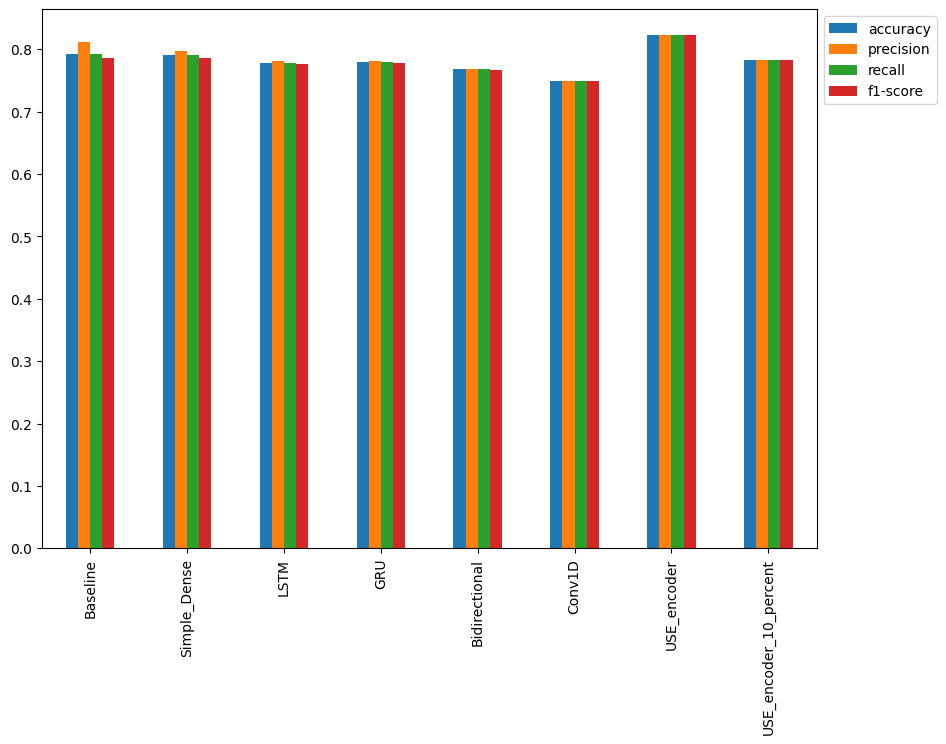

In [82]:
# Plot and compare all the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

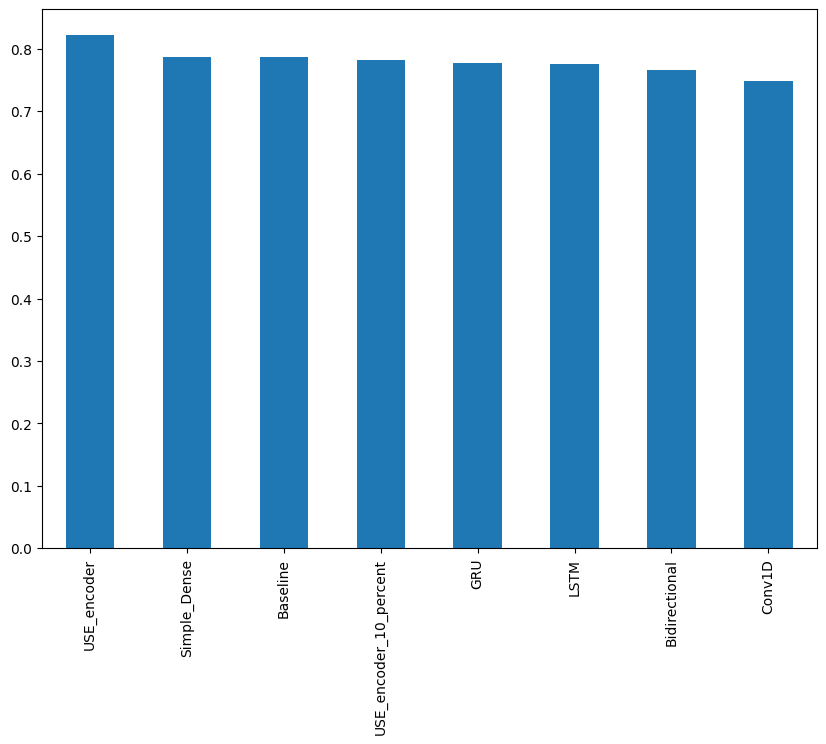

In [83]:
# Sort model esults by f1-score
all_model_results.sort_values("f1-score", ascending=False)["f1-score"].plot(kind="bar", figsize=(10, 7));

## Upload our model training logs to TensorBoard

In [84]:
# View TensorBoard logs of transfer learning modelling experiments
# Upload TensorBoard dev records
#!tensorboard dev upload  --logdir /content/model_logs \
#  --name "NLP Modelling Experiments ZTM Course" \
#  --description "Comparing different tyypes of model aarchitectures" \
#  --one_shot

## Saving and loading a trained model

There are two main formats to save a model:
1. HDF5
2. The 'SavedModel' (this is the default when using Tensorflow)

In [85]:
# Save Model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [86]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                     custom_objects={"KerasLayer": hub.KerasLayer})

In [87]:
# How does our loaded model perform
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4413 - accuracy: 0.8228


[0.4412502944469452, 0.8228346705436707]

In [88]:
model_6_results

{'accuracy': 82.28346456692913,
 'precision': 0.8229723973525771,
 'recall': 0.8228346456692913,
 'f1-score': 0.8222698311121005}

In [89]:
# Save to 'SaveModel' format
model_6.save("model_6_SaveModel")

In [90]:
# Load model in 'SaveModel' format
loaded_model_6_SaveModel = tf.keras.models.load_model("model_6_SaveModel")

In [91]:
loaded_model_6_SaveModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4413 - accuracy: 0.8228


[0.4412502944469452, 0.8228346705436707]

## Find the most wrong examples

In [92]:
# Download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-09-25 14:06:38--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  21.3MB/s    in 48s     

2023-09-25 14:07:26 (19.0 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.ind

In [93]:
# Import ZTM model
model_6_ZTM = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_ZTM.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 20ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [94]:
# Make predictions with the load model
model_6_ZTM_pred_probs = model_6_ZTM.predict(val_sentences)
model_6_ZTM_preds = tf.squeeze(tf.round(model_6_ZTM_pred_probs))

model_6_ZTM_preds[:10]

24/24 [==============================] - 1s 14ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [95]:
 # Create DataFrame with validation sentences and best performing model predictions
 val_df = pd.DataFrame({"text":val_sentences,
                        "target": val_labels,
                        "pred": model_6_ZTM_preds,
                        "pred_probs": tf.squeeze(model_6_ZTM_pred_probs)})
 val_df

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [96]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs", ascending=False)
most_wrong

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949


In [97]:
# Check the false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, {pred_prob}")
  print(f"Text: \n{text}\n")
  print(f"-------\n")

Target: 0, Pred: 1.0, 0.9101957678794861
Text: 
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-------

Target: 0, Pred: 1.0, 0.8769821524620056
Text: 
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-------

Target: 0, Pred: 1.0, 0.8523001074790955
Text: 
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-------

Target: 0, Pred: 1.0, 0.8354544043540955
Text: 
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-------

Target: 0, Pred: 1.0, 0.8272132873535156
Text: 
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-------

Target: 0, Pred: 1.0, 0.814815878868103
Text: 
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

-------

Target: 0,

## Making prediction on the test dataset

In [99]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_ZTM.predict([test_sample])) # The model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("------\n")

1/1 [==============================] - 0s 56ms/step
Pred: 0, Prob: 0.33402639627456665
Text:
Photo bombed by a princess http://t.co/i4PthsuYQ9

------

1/1 [==============================] - 0s 60ms/step
Pred: 1, Prob: 0.5844647288322449
Text:
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/FaXDzI90dY via @Change

------

1/1 [==============================] - 0s 65ms/step
Pred: 0, Prob: 0.07933752983808517
Text:
@jemmaswans i needed such a breather today oh my god i went on lunch and collapsed like a sack of bones in my car

------

1/1 [==============================] - 0s 60ms/step
Pred: 1, Prob: 0.902168869972229
Text:
Motorcyclist bicyclist injured in Denver collision on Broadway: At least two people were taken to a localÛ_ http://t.co/PMv8ZDFnmr

------

1/1 [==============================] - 0s 62ms/step
Pred: 0, Prob: 0.1335681825876236
Text:
Try not eating like a fat ass RT @INeedJa_Kadeeja: How much would i

### The speed/score tradeoff

In [102]:
# Function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter() # get end time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)

  return total_time, time_per_pred

In [103]:
model_6_ZTM_total_pred_time, model_6_ZTM_time_per_pred = pred_timer(model=model_6_ZTM,
                                                                    samples=val_sentences)

model_6_ZTM_total_pred_time, model_6_ZTM_time_per_pred

24/24 [==============================] - 0s 10ms/step


(0.35443680200000927, 0.00046514016010499904)

In [104]:
# Calculate baseline times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=baseline,
                                                              samples=val_sentences)

baseline_total_pred_time, baseline_time_per_pred

(0.030623132000073383, 4.018783727043751e-05)

In [105]:
model_6_ZTM_results = evaluate_model(model=model_6_ZTM,
                                 X_test=val_sentences,
                                 y_test=val_labels)

model_6_ZTM_results

24/24 [==============================] - 0s 9ms/step


{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1-score': 0.8148082644367335}

Text(0, 0.5, 'F1-Scpre')

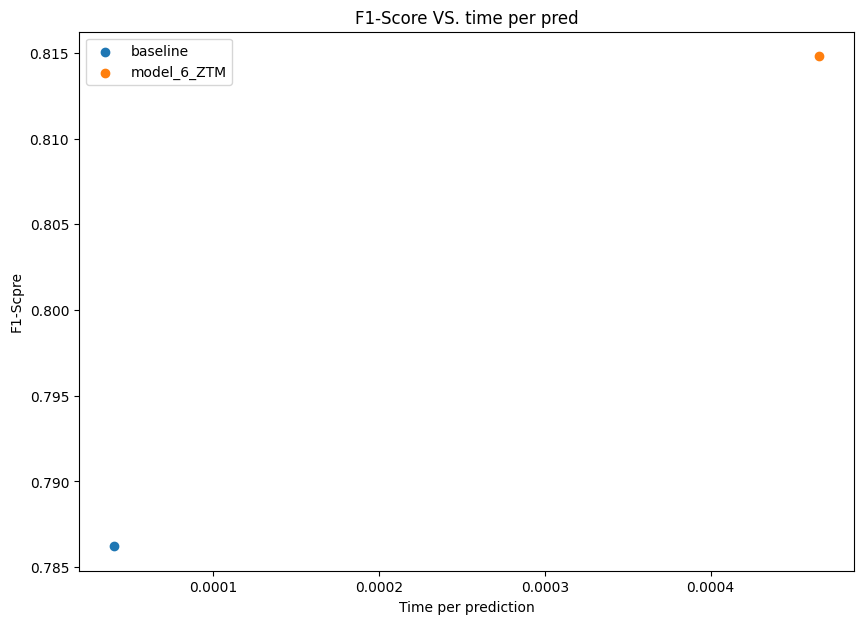

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1-score"], label="baseline")
plt.scatter(model_6_ZTM_time_per_pred, model_6_ZTM_results["f1-score"], label="model_6_ZTM")
plt.legend()
plt.title("F1-Score VS. time per pred")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Scpre")